# Rain Forecast in Australia

**Analysed by: Cezar Augusto Peixeiro dos Santos**

This study consists in analysing climate data retrieved by weather stations installed around some cities in Australia and from this predict the most probable rain condition (rainning or not) in the next day.

In [249]:
#main libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from czrpxrlib import countplot_top_prop_label
import warnings
warnings.simplefilter('ignore')

#models to be analyzed
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#metrics
from yellowbrick.model_selection import RFECV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest

In [2]:
all_files = os.listdir('data')
all_files.sort()

In [3]:
wind_data_lst = []

for file in all_files:
    if "rain" in file:
        rain_data = pd.read_csv('data/' + file)
    else:
        wind_data_lst.append(pd.read_csv('data/' + file))

## Data Handling

As I have many dataframes refering to the same kind of data, the next steps are verifications of possible errors that can let us to misunderstand the data and its correction.

* **Rain Dataframe - Columns names**

In [4]:
rain_data.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation',
       'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm',
       'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday',
       'amountOfRain', 'raintomorrow', 'temp', 'humidity', 'precipitation3pm',
       'precipitation9am', 'modelo_vigente'],
      dtype='object')

In [5]:
rain_data.columns = map(lambda x: x.lower(),rain_data.columns)

* **Wind Dataframes - Columns names**

In [6]:
#checking columns names (Using wind_data_lst[0] as reference)
for elem in range (0,len(wind_data_lst)):
    print(f"Dataframe {elem} - rows: {wind_data_lst[elem].shape[0]}, cols: {wind_data_lst[elem].shape[1]}. \
          \nColumns named as reference (0): {wind_data_lst[0].columns == wind_data_lst[elem].columns}")

Dataframe 0 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True  True  True  True  True  True  True]
Dataframe 1 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True  True  True  True  True  True  True]
Dataframe 2 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True False False False False False False]
Dataframe 3 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True False False False False False False]
Dataframe 4 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True False False False False False False]
Dataframe 5 - rows: 20000, cols: 8.           
Columns named as reference (0): [ True  True False False False False False False]
Dataframe 6 - rows: 22193, cols: 8.           
Columns named as reference (0): [ True  True False False False False False False]
Dataframe 7 - rows: 22193, cols: 8.           
Columns named as reference (0): [ True  True False

As we can see, the first column in all dataframes are standardized, but from index 2 to 7 the other columns don't match with its references in dataframe 0. So, I checked if the "False" columns are equal to each other looking for more differences. Than I made the necessary corrections and concatenate all wind dataframes in one.

In [7]:
for elem in range (2,len(wind_data_lst)):
    print(f"Dataframe {elem} - rows: {wind_data_lst[elem].shape[0]}, cols: {wind_data_lst[elem].shape[1]}. \
          \nColumns named as reference (2): {wind_data_lst[2].columns == wind_data_lst[elem].columns}")

Dataframe 2 - rows: 20000, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]
Dataframe 3 - rows: 20000, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]
Dataframe 4 - rows: 20000, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]
Dataframe 5 - rows: 20000, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]
Dataframe 6 - rows: 22193, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]
Dataframe 7 - rows: 22193, cols: 8.           
Columns named as reference (2): [ True  True  True  True  True  True  True  True]


In [8]:
wind_data_lst[0].columns = [name.replace("_","") for name in wind_data_lst[0].columns]
wind_data_lst[1].columns = [name.replace("_","") for name in wind_data_lst[0].columns]
wind_data = pd.concat(wind_data_lst)

### Merging Dataframes

In [9]:
rain_data.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,temp9am,temp3pm,raintoday,amountofrain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,...,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,...,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,...,21.0,23.2,No,0.0,No,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,...,18.1,26.5,No,1.0,No,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,...,17.8,29.7,No,0.2,No,40.76,41.600000,9,11.883546,0.220164


In [10]:
wind_data.head()

,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0


In [11]:
#all locations in the wind_data are also represented in rain_data
rain_unique_location = set(rain_data['location'].unique())
wind_unique_location = set(wind_data['location'].unique())
len(wind_unique_location.difference(rain_unique_location))

0

In [12]:
#all dates in the wind_data are also represented in rain_data
rain_unique_date = set(rain_data['date'].unique())
wind_unique_date = set(wind_data['date'].unique())
len(wind_unique_date.difference(rain_unique_date))

0

In [13]:
raw_weather = pd.merge(rain_data,wind_data, how="left", on=['date','location']).reset_index()

In [14]:
#Creating a backup to avoid possible reloading from folders
weather = raw_weather

In [15]:
weather.shape

(164386, 30)

### Identifying and Removing Duplicated Rows

In [16]:
print(f"Quantity of duplicated rows: {weather.duplicated(subset=['date','location']).sum()}")

Quantity of duplicated rows: 22193


In [17]:
weather.drop_duplicates(subset=['date','location'], inplace=True)

In [18]:
weather.reset_index(drop=True, inplace=True)
weather.shape

(142193, 30)

### Handling Datetime

In [19]:
weather['date'] = pd.to_datetime(weather['date'], yearfirst=True)

In [20]:
#Creating exclusive columns to possible use as groups in future steps
weather['month'] = [date.month for date in weather['date']]
weather['day'] = [date.day for date in weather['date']]
weather['year'] = [date.year for date in weather['date']]

In [21]:
#Putting similar data side by side
weather = weather[['date','year', 'month','day', 'location', 'temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm', 
                   'sunshine', 'rainfall', 'evaporation', 'amountofrain', 'raintoday', 'raintomorrow', 'humidity',
                   'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'precipitation3pm',
                   'precipitation9am', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am',
                   'windspeed3pm', 'modelo_vigente']]

### Numeric Data Overview

In [22]:
weather.drop(['year','month','day'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
temp,141871.0,28.505419,10.237506,-3.760000,22.520000,28.520000,35.480000,59.72000
mintemp,141556.0,12.186400,6.403283,-8.500000,7.600000,12.000000,16.800000,33.90000
maxtemp,141871.0,23.226784,7.117618,-4.800000,17.900000,22.600000,28.200000,48.10000
temp9am,141289.0,16.987509,6.492838,-7.200000,12.300000,16.700000,21.600000,40.20000
temp3pm,139467.0,21.687235,6.937594,-5.400000,16.600000,21.100000,26.400000,46.70000
sunshine,74377.0,7.624853,3.781525,0.000000,4.900000,8.500000,10.600000,14.50000
rainfall,140787.0,2.349974,8.465173,0.000000,0.000000,0.000000,0.800000,371.00000
evaporation,81350.0,5.469824,4.188537,0.000000,2.600000,4.800000,7.400000,145.00000
amountofrain,142193.0,2.360682,8.477969,0.000000,0.000000,0.000000,0.800000,371.00000
humidity,138583.0,61.991179,26.649111,2.000000,44.000000,63.200000,80.000000,122.00000


**Insights**
- temp values are higher than maxtemp
- amountofrain and rainfall have very close values
- cloud9am and cloud3pm maximum values are higher than the maximum value accepted by the unit of measure.
- precipitation9am minimum values are negative (not accepted by the unit of measure)

### Missing Values Overview

In [23]:
missing = pd.Series(weather.isna().sum())
missing_prop = pd.Series(weather.isna().sum() / weather.shape[0])
pd.DataFrame({'missing': missing, 'missing_prop': missing_prop, 'dtypes': weather.dtypes})

,missing,missing_prop,dtypes
date,0,0.000000,datetime64[ns]
year,0,0.000000,int64
month,0,0.000000,int64
day,0,0.000000,int64
location,0,0.000000,object
temp,322,0.002265,float64
mintemp,637,0.004480,float64
maxtemp,322,0.002265,float64
temp9am,904,0.006358,float64
temp3pm,2726,0.019171,float64


**Insights**
- Great quantity of missing values in cloud9am, cloud3pm, sunshine and evaporation. But the majority of data do not exceed 10% of missing values.

In [24]:
#Replacing data in raintomorrow and raintoday to 0 and 1
weather.loc[:,"raintomorrow"] = weather.loc[:,"raintomorrow"].apply(lambda x: 1 if x == "Yes" else 0)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
weather.loc[:,"raintoday"] = weather.loc[:,"raintoday"].apply(lambda x: 1 if x == "Yes" else (0 if x == "No" else None))

In [26]:
dirs = {j:i for i,j in enumerate(weather['windgustdir'].unique())}
weather.loc[:,['windgustdir','winddir3pm','winddir9am']] = weather.loc[:,['windgustdir','winddir3pm','winddir9am']].replace(dirs)

## Data Handling

* **Sunshine and wind direction columns**

These columns have a similar behavior when thinking about consecutive days. So, the missing values of this columns was filled with the previous valid day value in the columns

In [27]:
weather.loc[:,['sunshine','windgustdir','winddir9am','winddir3pm']] = weather.loc[:,['sunshine','windgustdir','winddir9am','winddir3pm']].fillna(method='ffill')
weather.loc[:,['sunshine','windgustdir','winddir9am','winddir3pm']] = weather.loc[:,['sunshine','windgustdir','winddir9am','winddir3pm']].fillna(method='bfill')

* **Temperature columns**

A strange situation was observed in **temp** column:

In [28]:
weather.loc[:,['temp','mintemp','maxtemp','temp9am','temp3pm']].head()

,temp,mintemp,maxtemp,temp9am,temp3pm
0,29.48,13.4,22.9,16.9,21.8
1,32.12,7.4,25.1,17.2,24.3
2,32.84,12.9,25.7,21.0,23.2
3,35.60,9.2,28.0,18.1,26.5
4,40.76,17.5,32.3,17.8,29.7


Logically their values must be within a range between **mintemp** and **maxtemp**. The same is true for both **temp9am** and **temp3pm** columns. Below I checked how many rows met this definition:

In [29]:
#How many temp rows are trustworthy
print(f" Absolute: {weather.loc[(weather['temp'] >= weather['mintemp']) & (weather['temp'] <= weather['maxtemp']),:].shape[0]}\n \
Proportion: {weather.loc[(weather['temp'] >= weather['mintemp']) & (weather['temp'] <= weather['maxtemp']),:].shape[0] / weather.shape[0]}")

 Absolute: 422
 Proportion: 0.0029677972895993474


In [30]:
#How many temp9am rows are trustworthy
print(f" Absolute: {weather.loc[(weather['temp9am'] >= weather['mintemp']) & (weather['temp9am'] <= weather['maxtemp']),:].shape[0]}\n \
Proportion: {weather.loc[(weather['temp9am'] >= weather['mintemp']) & (weather['temp9am'] <= weather['maxtemp']),:].shape[0] / weather.shape[0]}")

 Absolute: 140764
 Proportion: 0.9899502788463567


In [31]:
#How many temp3pm rows are trustworthy
print(f" Absolute: {weather.loc[(weather['temp3pm'] >= weather['mintemp']) & (weather['temp3pm'] <= weather['maxtemp']),:].shape[0]}\n \
Proportion: {weather.loc[(weather['temp3pm'] >= weather['mintemp']) & (weather['temp3pm'] <= weather['maxtemp']),:].shape[0] / weather.shape[0]}")

 Absolute: 137776
 Proportion: 0.9689365861891935


A very low amount of rows in **temp** column was consistent. So, this column was dropped.

In [32]:
weather.drop('temp', axis=1, inplace=True)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Visualizing **maxtemp** and **mintemp** missing values

In [33]:
print(f"Missing values mintemp: {weather['mintemp'].isna().sum()}\nMissing values maxtemp: {weather['maxtemp'].isna().sum()}")

Missing values mintemp: 637
Missing values maxtemp: 322


Funneling the variables (Canberra as example visualization)

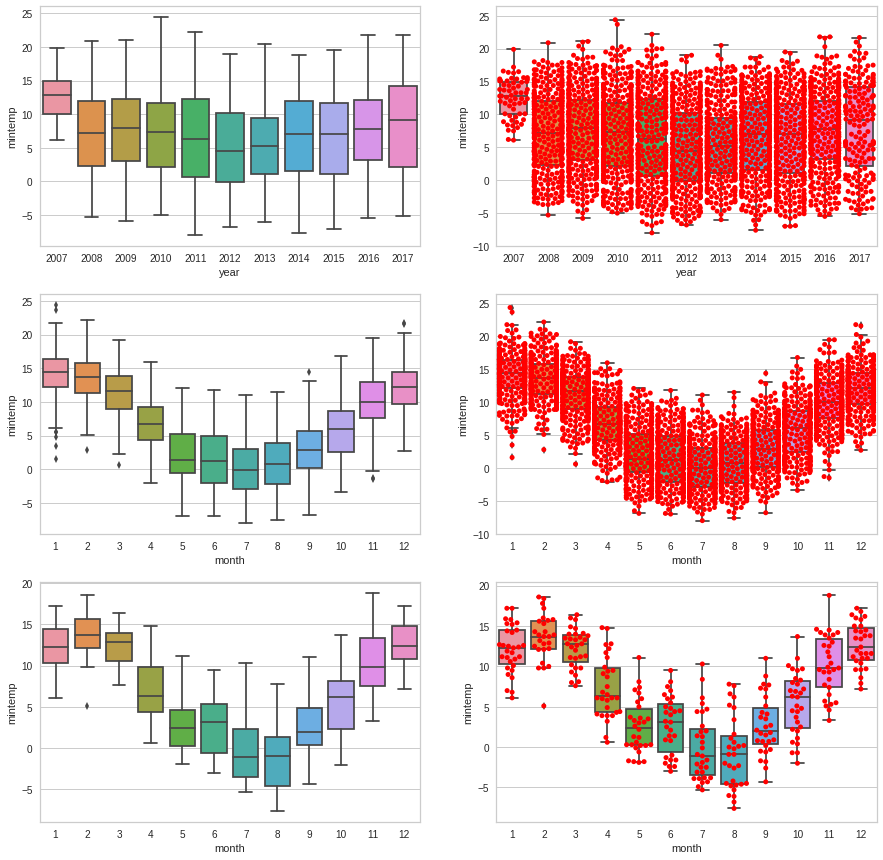

In [34]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
sns.boxplot('year','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[0,0])
sns.boxplot('year','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[0,1])
sns.swarmplot('year','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[0,1], color="red")

sns.boxplot('month','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[1,0])
sns.boxplot('month','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[1,1])
sns.swarmplot('month','mintemp', data=weather.loc[weather['location'] == 'Canberra',:], ax=axes[1,1], color="red")

sns.boxplot('month','mintemp', data=weather.loc[(weather['location'] == 'Canberra') & (weather['year'] == 2014),:], ax=axes[2,0])
sns.boxplot('month','mintemp', data=weather.loc[(weather['location'] == 'Canberra') & (weather['year'] == 2014),:], ax=axes[2,1])
sns.swarmplot('month','mintemp', data=weather.loc[(weather['location'] == 'Canberra') & (weather['year'] == 2014),:], ax=axes[2,1], color="red");

The same behavior is seen in other numerical columns that are season dependent (all temperature, rainfall, evaporation, amountofrain, humidities, preasures, precipitations and windspeeds).

About temperature values, filling these missing values with median using year, month and location as references:

In [35]:
temp_medians = weather[['year','month','location','mintemp','maxtemp','temp9am','temp3pm']].groupby(['year','month','location']).median()
temp_medians.head()

mintemp  maxtemp  temp9am  temp3pm
year month location                                    
2007 11    Canberra     12.4    24.75     16.9     23.8
     12    Canberra     13.8    24.80     17.4     22.5
2008 1     Canberra     15.4    29.90     19.3     27.9
     2     Canberra     12.4    24.80     16.3     24.0
           Sydney       18.9    24.80     21.3     23.5

In [36]:
for key, data in weather.iterrows():
    if np.isnan(data['mintemp']):
        weather.loc[key,'mintemp'] = temp_medians.loc[(data['year'],data['month'],data['location']),'mintemp']
    if np.isnan(data['maxtemp']):
        weather.loc[key,'maxtemp'] = temp_medians.loc[(data['year'],data['month'],data['location']),'maxtemp']

**Missing values checking (after substitution)**

In [37]:
print(f"Missing values mintemp: {weather['mintemp'].isna().sum()}\nMissing values maxtemp: {weather['maxtemp'].isna().sum()}")

Missing values mintemp: 1
Missing values maxtemp: 1


In [38]:
weather.loc[weather['mintemp'].isna(),:]

,date,year,month,day,location,mintemp,maxtemp,temp9am,temp3pm,sunshine,...,cloud3pm,precipitation3pm,precipitation9am,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,modelo_vigente
67758,2016-04-30,2016,4,30,Melbourne,NaN,NaN,NaN,NaN,8.4,...,NaN,6,7.481963,5,76.0,5,5,31.0,35.0,0.473256


In [39]:
weather.dropna(axis=0, subset=['mintemp'], inplace=True)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Verifying the non consistent rows for **temp9am** and **temp3pm**

In [40]:
print(f"Missing values temp9am: {weather['temp9am'].isna().sum()}\nMissing values temp3pm: {weather['temp3pm'].isna().sum()}")

Missing values temp9am: 903
Missing values temp3pm: 2725


The same logic used in **mintemp** and **maxtemp** to fill the missing values with median values was used below, but taking care with **mintemp** and **maxtemp** as limits:

In [41]:
for key, data in weather.iterrows():
    for i in temp_medians.columns[2:]:
        if np.isnan(data[i]):
            md = temp_medians.loc[(data['year'],data['month'],data['location']),i]
            if (md >= data['mintemp']) & (md <= data['maxtemp']):
                weather.loc[key,i] = md

In [42]:
print(f"Missing values temp9am: {weather['temp9am'].isna().sum()}\nMissing values temp3pm: {weather['temp3pm'].isna().sum()}")

Missing values temp9am: 168
Missing values temp3pm: 2257


This idea of replacement was not enough to all missing values. So I went some steps backwards with the filter:


In [43]:
#Month and location
temp_medians2 = weather[['month','location','temp9am','temp3pm']].groupby(['month','location']).median()

#Only location
temp_medians3 = weather[['location','temp9am','temp3pm']].groupby(['location']).median()

In [44]:
for key, data in weather.iterrows():
    for i in temp_medians2.columns:
        if np.isnan(data[i]):
            md = temp_medians2.loc[(data['month'],data['location']),i]
            if (md >= data['mintemp']) & (md <= data['maxtemp']):
                weather.loc[key,i] = md

In [45]:
print(f"Missing values temp9am: {weather['temp9am'].isna().sum()}\nMissing values temp3pm: {weather['temp3pm'].isna().sum()}")

Missing values temp9am: 130
Missing values temp3pm: 752


In [46]:
for key, data in weather.iterrows():
    for i in temp_medians3.columns:
        if np.isnan(data[i]):
            md = temp_medians3.loc[data['location'],i]
            if (md >= data['mintemp']) & (md <= data['maxtemp']):
                weather.loc[key,i] = md

In [47]:
print(f"Missing values temp9am: {weather['temp9am'].isna().sum()}\nMissing values temp3pm: {weather['temp3pm'].isna().sum()}")

Missing values temp9am: 95
Missing values temp3pm: 463


The remaining values not filled weren't a significant numbers. So, they were dropped.

In [48]:
weather.dropna(axis=0, subset=['temp9am','temp3pm'], how='any', inplace=True)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Rainfall and Amountofrain

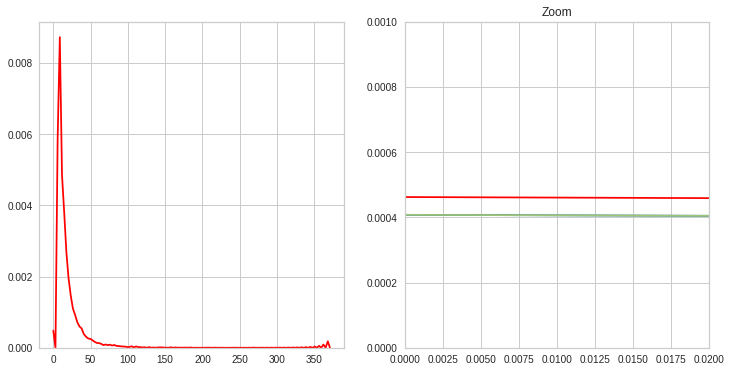

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
sns.distplot(weather['rainfall'].dropna(), color='red', hist=False, ax=ax1)
sns.distplot(weather['amountofrain'].dropna(), hist=False, ax=ax2)
ax1.set_xlabel("")

sns.distplot(weather['rainfall'].dropna(), color='red', hist=False, ax=ax2)
sns.distplot(weather['amountofrain'].dropna(), hist=False, ax=ax2)
ax2.set_xlim([0,0.02])
ax2.set_ylim([0,0.001])
ax2.set_title("Zoom")
ax2.set_xlabel("");

In [50]:
weather.loc[:,['rainfall','amountofrain']].isna().sum()

rainfall        1378
amountofrain       0
dtype: int64

In [51]:
weather.loc[:,['rainfall','amountofrain']].head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
rainfall,0.6,0.0,0.0,0.0,1.0,0.2,0.0,0.0,0.0,1.4,0.0,2.2,15.6,3.6,NaN,0.0,16.8,10.6,0.0,0.0
amountofrain,0.0,0.0,0.0,1.0,0.2,0.0,0.0,0.0,1.4,0.0,2.2,15.6,3.6,0.0,0.0,16.8,10.6,0.0,0.0,0.0


In [52]:
weather[['rainfall','amountofrain']].corr()

,rainfall,amountofrain
rainfall,1.000000,0.307599
amountofrain,0.307599,1.000000


The conclusion is that rainfall is just a copy of amountofrain shifted one step down and some values was lost. So, the rainfall column was dropped.

In [53]:
weather.drop('rainfall', axis=1, inplace=True)

### Cloud columns

There are three values with measure higher than the allowed unit. They were dropped.

In [54]:
over_cloud_rows = weather.loc[(weather['cloud9am'] == 9) | (weather['cloud3pm'] == 9),:]
over_cloud_rows

,date,year,month,day,location,mintemp,maxtemp,temp9am,temp3pm,sunshine,...,cloud3pm,precipitation3pm,precipitation9am,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,modelo_vigente
30097,2009-09-23,2009,9,23,Sydney,17.0,21.8,17.3,20.9,8.0,...,3.0,10,11.419590,14,NaN,0,0,30.0,37.0,0.120108
45981,2012-05-27,2012,5,27,Canberra,0.6,14.5,4.4,14.2,7.8,...,NaN,10,12.398522,7,30.0,4,16,4.0,9.0,0.024968
104342,2012-11-02,2012,11,2,Woomera,10.6,24.6,14.8,23.7,11.4,...,9.0,11,12.905862,9,39.0,12,13,26.0,17.0,0.011199


In [55]:
weather.drop(over_cloud_rows.index, axis=0, inplace=True)

With this issue solved, the missing values were filled with the same idea of sunshine values (smiliar behavior in consecutive days)

In [56]:
weather.loc[:,['cloud9am', 'cloud3pm']] = weather.loc[:,['cloud9am', 'cloud3pm']].fillna(method='ffill')
weather.loc[:,['cloud9am', 'cloud3pm']] = weather.loc[:,['cloud9am', 'cloud3pm']].fillna(method='bfill')

### Humidities, Pressures, Winds, Evaporation

These variables follow the same logic as temperature, but without any range limitating the values.

In [57]:
medians_mask = weather[['year','month','location','evaporation', 'humidity','humidity9am','humidity3pm','pressure9am','pressure3pm',
                        'windspeed9am','windspeed3pm', 'windgustspeed']]
rem_medians = medians_mask.groupby(['year','month','location']).median()
rem_medians.head()

evaporation  humidity  humidity9am  humidity3pm  \
year month location                                                    
2007 11    Canberra          6.0      43.4         68.5         35.5   
     12    Canberra          6.2      57.2         69.0         48.0   
2008 1     Canberra          7.4      44.0         66.0         36.0   
     2     Canberra          5.8      51.2         73.0         41.0   
           Sydney            5.5      76.4         78.0         62.0   

                     pressure9am  pressure3pm  windspeed9am  windspeed3pm  \
year month location                                                         
2007 11    Canberra      1018.75      1014.95           6.0          17.0   
     12    Canberra      1015.80      1014.10           7.0          15.0   
2008 1     Canberra      1014.60      1012.30           7.0          15.0   
     2     Canberra      1013.60      1011.40           9.0          15.0   
           Sydney        1014.10      1011.80          13.0          20.0   

                     windgustspeed  
year month location                 
2007 11    Canberra           41.0  
     12    Canberra           41.0  
2008 1     Canberra           43.0  
     2     Canberra           41.0  
           Sydney              NaN

In [58]:
#Filtering by year, month and location
for key, data in weather.iterrows():
    for i in rem_medians.columns:
        if np.isnan(data[i]):
            md = rem_medians.loc[(data['year'],data['month'],data['location']),i]
            weather.loc[key,i] = md

In [59]:
for name in rem_medians.columns:
    print(f"Missing values {name}: {weather[name].isna().sum()}")

Missing values evaporation: 55931
Missing values humidity: 2097
Missing values humidity9am: 419
Missing values humidity3pm: 2097
Missing values pressure9am: 13339
Missing values pressure3pm: 13339
Missing values windspeed9am: 472
Missing values windspeed3pm: 1565
Missing values windgustspeed: 7324


In [60]:
#Month and location
rem2_medians = medians_mask.drop('year', axis=1).groupby(['month','location']).median()

#Location
rem3_medians = medians_mask.loc[:,['location','evaporation','pressure9am','pressure3pm','windgustspeed']].groupby(['location']).median()

In [61]:
#Filtering by month and location
for key, data in weather.iterrows():
    for i in rem2_medians.columns:
        if np.isnan(data[i]):
            md = rem2_medians.loc[(data['month'],data['location']),i]
            weather.loc[key,i] = md

In [62]:
for name in rem2_medians.columns:
    print(f"Missing values {name}: {weather[name].isna().sum()}")

Missing values evaporation: 45253
Missing values humidity: 0
Missing values humidity9am: 0
Missing values humidity3pm: 0
Missing values pressure9am: 11569
Missing values pressure3pm: 11569
Missing values windspeed9am: 0
Missing values windspeed3pm: 0
Missing values windgustspeed: 5715


In [63]:
#Filtering by location
for key, data in weather.iterrows():
    for i in rem3_medians.columns:
        if np.isnan(data[i]):
            md = rem3_medians.loc[(data['location']),i]
            weather.loc[key,i] = md


In [64]:
for name in rem3_medians.columns:
    print(f"Missing values {name}: {weather[name].isna().sum()}")

Missing values evaporation: 44033
Missing values pressure9am: 11569
Missing values pressure3pm: 11569
Missing values windgustspeed: 5715


An iteration using only location as filter was tryied, but just a little quantity os evaporation missing values was replaced. So, the remaining rows were dropped.

In [65]:
weather.dropna(axis=0, how='any', subset=['pressure9am','pressure3pm','windgustspeed', 'evaporation'], inplace=True)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Raintoday vs Precipiration 9am

In [66]:
weather.loc[:,['date','precipitation9am','precipitation3pm','raintoday']].head()

,date,precipitation9am,precipitation3pm,raintoday
5939,2009-01-01,15.165784,5,0.0
5940,2009-01-02,9.750834,9,0.0
5941,2009-01-03,11.954782,11,0.0
5942,2009-01-04,5.557986,11,0.0
5943,2009-01-05,17.820001,10,0.0


In [67]:
weather.loc[:,['precipitation9am','precipitation3pm']].corr()

,precipitation9am,precipitation3pm
precipitation9am,1.000000,0.002434
precipitation3pm,0.002434,1.000000


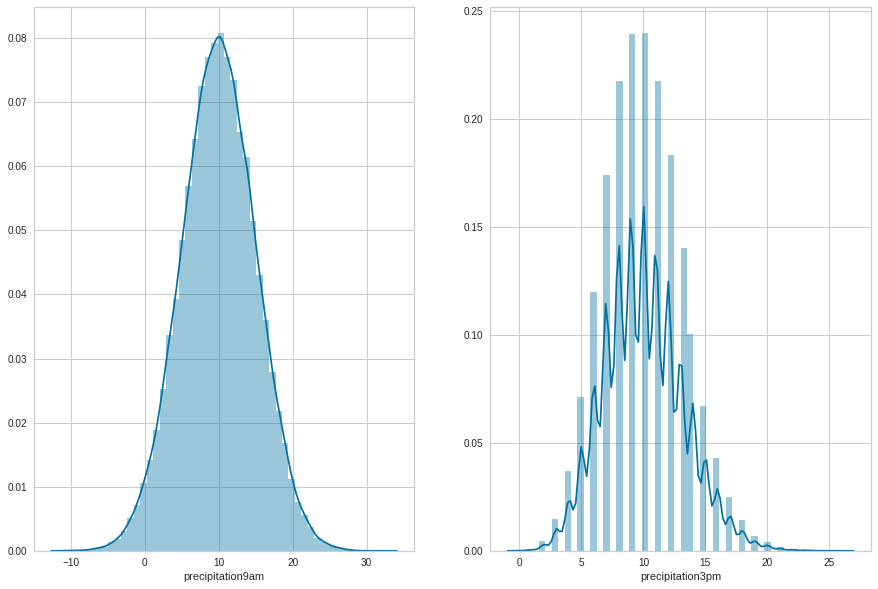

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))
sns.distplot(weather['precipitation9am'], ax=ax1)
sns.distplot(weather['precipitation3pm'], ax=ax2);

Besides the negative values of **precipitation9am** the data about raintoday says *"Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0"*, but it doesn't make sense. As we can see above both columns seems to be artificially created with as normal distributions. It was decided to drop them.

In [69]:
weather.drop(['precipitation9am','precipitation3pm'], axis=1, inplace=True)

### Raintoday Remaining

There is a remaining of NaN values in the raintoday colums. Being a low number, they were dropped.

In [70]:
weather.dropna(axis=0,subset=['raintoday'], how='any', inplace=True)

/home/czrpxr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Corrections

In [71]:
weather.reset_index(drop=True, inplace=True)

In [72]:
weather = weather.astype({'raintoday':'category',
                          'raintomorrow': 'category',
                          'cloud9am': 'int64',
                          'cloud3pm': 'int64',
                          'windgustdir':'category',
                          'windgustspeed': 'int64',
                          'winddir3pm':'category', 
                          'winddir9am':'category', 
                          'windspeed9am': 'int64',
                          'windspeed3pm': 'int64',
                          })

Date and location colum were used initially to generate year, month and day columns and to be a support if need. At this step of the analysis, it can be dropped. 

In [73]:
weather.drop(['date','location'], axis=1, inplace=True)

In [74]:
#creating a cleaned security copy
weather_ml = weather

### Visualizing Target

In [75]:
samples_dist = weather_ml.sample(frac=0.2, random_state=42)

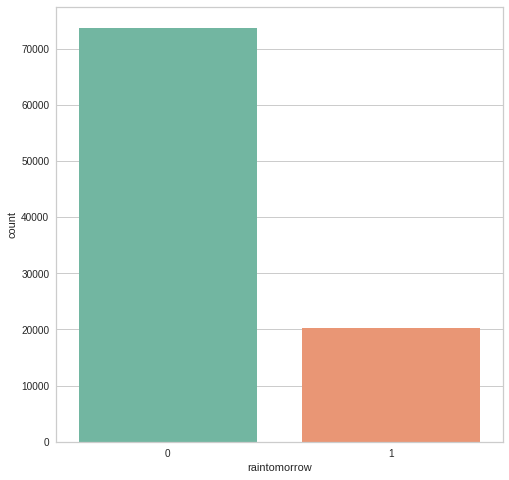

In [243]:
plt.figure(figsize=(8,8))
sns.countplot(weather_ml.loc[:,'raintomorrow'], palette="Set2")
#countplot_top_prop_label(ax,weather,14)

The samples with no rain is almost more than 3,5 times the amount of rainy days.

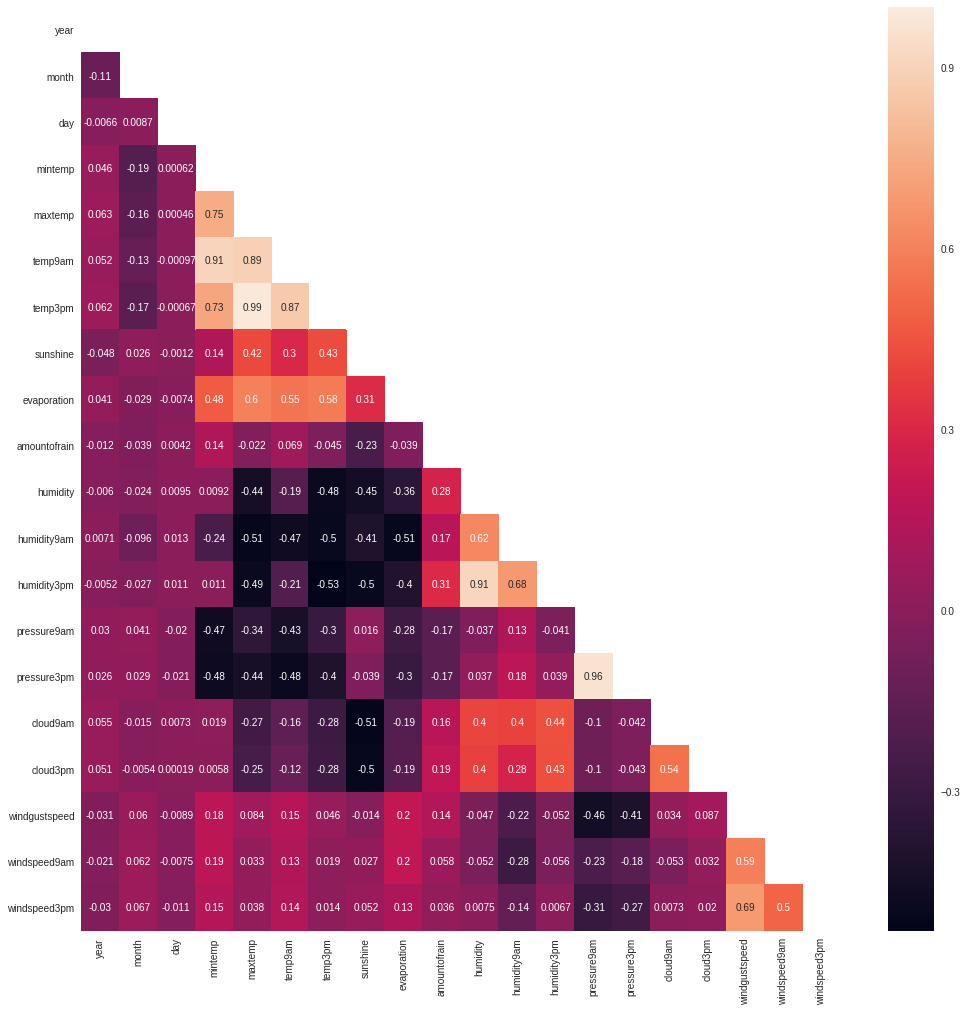

In [78]:
mask = np.zeros_like(weather_ml.drop('modelo_vigente', axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(17,17))
sns.heatmap(weather_ml.drop('modelo_vigente', axis=1).corr(), annot=True, mask = mask);

In [79]:
weather_ml.loc[:,'modelo_vigente'].describe()

count    94049.000000
mean         0.220403
std          0.273405
min          0.000000
25%          0.024454
50%          0.092304
75%          0.309196
max          0.999400
Name: modelo_vigente, dtype: float64

In [80]:
weather_ml.loc[:,['modelo_vigente','raintomorrow']].head(10).T

,0,1,2,3,4,5,6,7,8,9
modelo_vigente,0.0113198,0.00168333,0.0546806,0.0610262,0.0107238,0.103292,0.177723,0.00791667,0.0008,0.0315238
raintomorrow,0,0,0,0,0,0,0,0,0,0


- There are variables with big correlations as the temperature group, humidity vs humidity3pm and pressure3pm vs pressure9am.
- Modelo_vigente seems to be the probability of rain considering the actual running model. It was used as reference

### Models Testing

Four models were chosen to estimate the target: Logistic Regression, SVM, Random Forest and KNN.

**Instantiating them and analysing results with default data**

* Splitting data

In [254]:
s_weather_ml = weather_ml.sample(frac=0.1, axis=0)

In [292]:
y = s_weather_ml.loc[:,'raintomorrow']
X = s_weather_ml.drop(['raintomorrow','modelo_vigente'], axis=1)

#Using Stratified Kfold to analyze
skf = StratifiedKFold(n_splits=5, random_state=42)

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.4, random_state=42)

In [302]:
svm_default = SVC(gamma='auto', random_state=42, probability=True)
dtree_default = RandomForestClassifier(random_state=42)
logreg_default = LogisticRegression(solver='lbfgs', random_state=42)
knn_default = KNeighborsClassifier()

### Selecting Best Features

In [295]:
select = SelectKBest(k=15)
selected = select.fit(X_train, y_train)
ind_selected = selected.get_support(indices=True)
col_selected = [X.columns[i] for i in ind_selected]
print(col_selected)

['maxtemp', 'temp3pm', 'sunshine', 'evaporation', 'amountofrain', 'raintoday', 'humidity', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'windgustspeed', 'windspeed3pm']


In [260]:
X_test_new = X_test.loc[:,col_selected]
X_train_new = X_train.loc[:,col_selected]

### Predicting using standard X_test and X_train

In [261]:
svm_default.fit(X_train,y_train)
ypred_svm = svm_default.predict(X_test)
ypred_train_svm = svm_default.predict(X_train)
roc_dist_svm = {'test': roc_auc_score(y_test,ypred_svm),'train': roc_auc_score(y_train,ypred_train_svm)}

dtree_default.fit(X_train, y_train)
ypred_dtree = dtree_default.predict(X_test)
ypred_train_dtree = dtree_default.predict(X_train)
roc_dist_dtree = {'test': roc_auc_score(y_test,ypred_dtree),'train': roc_auc_score(y_train,ypred_train_dtree)}

logreg_default.fit(X_train, y_train)
ypred_logreg = logreg_default.predict(X_test)
ypred_train_logreg = logreg_default.predict(X_train)
roc_dist_logreg = {'test': roc_auc_score(y_test,ypred_logreg),'train': roc_auc_score(y_train,ypred_train_logreg)}

knn_default.fit(X_train, y_train)
ypred_knn = knn_default.predict(X_test)
ypred_train_knn = knn_default.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [262]:
print(f"SVM - {roc_dist_svm}\nDTREE - {roc_dist_dtree}\nLOGREG - {roc_dist_logreg}\nKNN - {roc_dist_knn}")

SVM - {'test': 0.5, 'train': 1.0}
DTREE - {'test': 1.0, 'train': 1.0}
LOGREG - {'test': 0.9607472942165449, 'train': 0.9675366209973546}
KNN - {'test': 0.7443080321450273, 'train': 0.809144391360998}


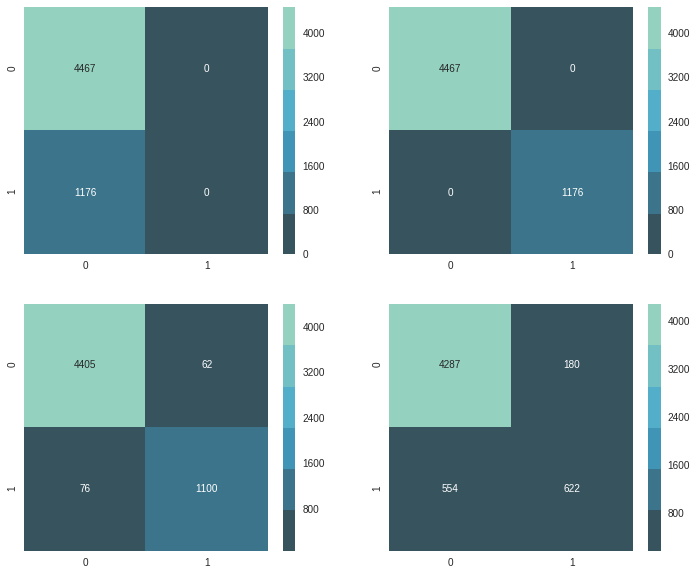

In [263]:
clr = sns.color_palette("GnBu_d")
fig, ax = plt.subplots(2,2, figsize=(12,10))
sns.heatmap(confusion_matrix(y_test,ypred_svm), annot=True, fmt=".0f", ax=ax[0,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_dtree), annot=True, fmt=".0f", ax=ax[0,1], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_logreg), annot=True, fmt=".0f", ax=ax[1,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_knn), annot=True, fmt=".0f", ax=ax[1,1], cmap=clr);

In [265]:
svm_default.fit(X_train_new,y_train)
ypred_svm2 = svm_default.predict(X_test_new)
ypred_train_svm2 = svm_default.predict(X_train_new)
roc_dist_svm2 = {'test': roc_auc_score(y_test,ypred_svm2),'train': roc_auc_score(y_train,ypred_train_svm2)}

dtree_default.fit(X_train_new, y_train)
ypred_dtree2 = dtree_default.predict(X_test_new)
ypred_train_dtree2 = dtree_default.predict(X_train_new)
roc_dist_dtree2 = {'test': roc_auc_score(y_test,ypred_dtree2),'train': roc_auc_score(y_train,ypred_train_dtree2)}

logreg_default.fit(X_train_new, y_train)
ypred_logreg2 = logreg_default.predict(X_test_new)
ypred_train_logreg2 = logreg_default.predict(X_train_new)
roc_dist_logreg2 = {'test': roc_auc_score(y_test,ypred_logreg2),'train': roc_auc_score(y_train,ypred_train_logreg2)}

knn_default.fit(X_train_new, y_train)
ypred_knn2 = knn_default.predict(X_test_new)
ypred_train_knn2 = knn_default.predict(X_train_new)
roc_dist_knn2 = {'test': roc_auc_score(y_test,ypred_knn2),'train': roc_auc_score(y_train,ypred_train_knn2)}

In [266]:
print(f"SVM - {roc_dist_svm2}\nDTREE - {roc_dist_dtree2}\nLOGREG - {roc_dist_logreg2}\nKNN - {roc_dist_knn2}")

SVM - {'test': 0.5, 'train': 1.0}
DTREE - {'test': 0.994987333415569, 'train': 1.0}
LOGREG - {'test': 0.9835737014752173, 'train': 0.9844987562680144}
KNN - {'test': 0.7504400181832303, 'train': 0.8216172464168674}


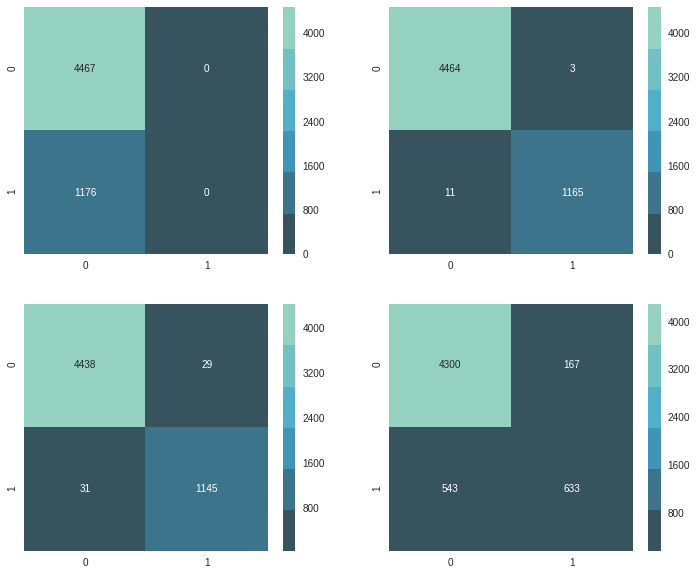

In [267]:
clr = sns.color_palette("GnBu_d")
fig, ax = plt.subplots(2,2, figsize=(12,10))
sns.heatmap(confusion_matrix(y_test,ypred_svm2), annot=True, fmt=".0f", ax=ax[0,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_dtree2), annot=True, fmt=".0f", ax=ax[0,1], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_logreg2), annot=True, fmt=".0f", ax=ax[1,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_knn2), annot=True, fmt=".0f", ax=ax[1,1], cmap=clr);

### Using Stratified KFold with selected features

In [273]:
class_def = [svm_default, dtree_default, logreg_default, knn_default]
class_def_names = ['svm_default', 'dtree_default', 'logreg_default', 'knn_default']

roc_test = {'logreg_default':[],'svm_default':[],'dtree_default':[], 'knn_default':[]}
roc_train = {'logreg_default':[],'svm_default':[],'dtree_default':[], 'knn_default':[]}

X_selected = X.loc[:,col_selected]
for train_index, test_index in skf.split(X_selected, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for cf, cfn in zip(class_def,class_def_names):
        cf.fit(X_train,y_train)
        y_pred = cf.predict(X_test)
        y_pred_train = cf.predict(X_train)
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_train = roc_auc_score(y_train, y_pred_train)
        roc_test[cfn].append(roc_score)
        roc_train[cfn].append(roc_score_train)

In [275]:
pd.DataFrame(roc_test)

,logreg_default,svm_default,dtree_default,knn_default
0,0.954264,0.5,1.0,0.741625
1,0.933298,0.5,1.0,0.757966
2,0.935126,0.5,1.0,0.753567
3,0.982714,0.5,1.0,0.738551
4,0.950539,0.5,1.0,0.759570


In [276]:
pd.DataFrame(roc_train)

,logreg_default,svm_default,dtree_default,knn_default
0,0.953764,1.0,1.0,0.805621
1,0.927449,1.0,1.0,0.800555
2,0.943218,1.0,1.0,0.799241
3,0.978301,1.0,1.0,0.804750
4,0.964860,1.0,1.0,0.797094


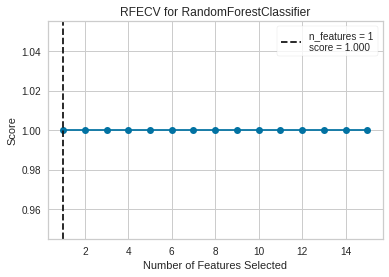

In [285]:
cv = StratifiedKFold(5)
viz_dtree = RFECV(dtree_default, cv=cv, scoring="roc_auc")

viz_dtree.fit(X_selected, y)
viz_dtree.show()   

In [286]:
viz_dtree.ranking_

array([12, 10,  4, 14,  1,  9,  3,  8,  2,  6,  7, 13, 11,  5, 15])

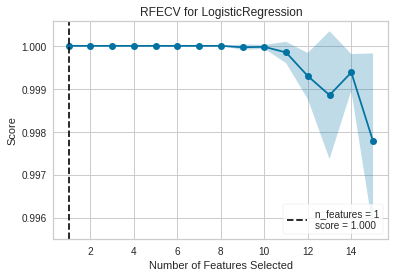

In [282]:
cv = StratifiedKFold(5)
visualizer = RFECV(logreg_default, cv=cv, scoring="roc_auc")

visualizer.fit(X_selected, y)
visualizer.show()  

In [283]:
visualizer.ranking_

array([ 5, 15,  8,  7,  1,  2, 13, 12, 11,  4,  3, 10,  9, 14,  6])

In [284]:
X_selected.columns

Index(['maxtemp', 'temp3pm', 'sunshine', 'evaporation', 'amountofrain',
       'raintoday', 'humidity', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'windgustspeed', 'windspeed3pm'],
      dtype='object')

### Running Models without amountofrain column

In [296]:
X_test_new2 = X_test_new.drop('amountofrain', axis=1)
X_train_new2 = X_train_new.drop('amountofrain', axis=1)

In [297]:
svm_default.fit(X_train_new2,y_train)
ypred_svm3 = svm_default.predict(X_test_new2)
ypred_train_svm3 = svm_default.predict(X_train_new2)
roc_dist_svm3 = {'test': roc_auc_score(y_test,ypred_svm3),'train': roc_auc_score(y_train,ypred_train_svm3)}

dtree_default.fit(X_train_new2, y_train)
ypred_dtree3 = dtree_default.predict(X_test_new2)
ypred_train_dtree3 = dtree_default.predict(X_train_new2)
roc_dist_dtree3 = {'test': roc_auc_score(y_test,ypred_dtree3),'train': roc_auc_score(y_train,ypred_train_dtree3)}

logreg_default.fit(X_train_new2, y_train)
ypred_logreg3 = logreg_default.predict(X_test_new2)
ypred_train_logreg3 = logreg_default.predict(X_train_new2)
roc_dist_logreg3 = {'test': roc_auc_score(y_test,ypred_logreg3),'train': roc_auc_score(y_train,ypred_train_logreg3)}

knn_default.fit(X_train_new2, y_train)
ypred_knn3 = knn_default.predict(X_test_new2)
ypred_train_knn3 = knn_default.predict(X_train_new2)
roc_dist_knn3 = {'test': roc_auc_score(y_test,ypred_knn3),'train': roc_auc_score(y_train,ypred_train_knn3)}

In [298]:
print(f"SVM - {roc_dist_svm3}\nDTREE - {roc_dist_dtree3}\nLOGREG - {roc_dist_logreg3}\nKNN - {roc_dist_knn3}")

SVM - {'test': 0.5, 'train': 1.0}
DTREE - {'test': 0.6955019919317627, 'train': 0.9703873336755242}
LOGREG - {'test': 0.7257992854630099, 'train': 0.7337150076992932}
KNN - {'test': 0.7126841166285185, 'train': 0.7781774390966162}


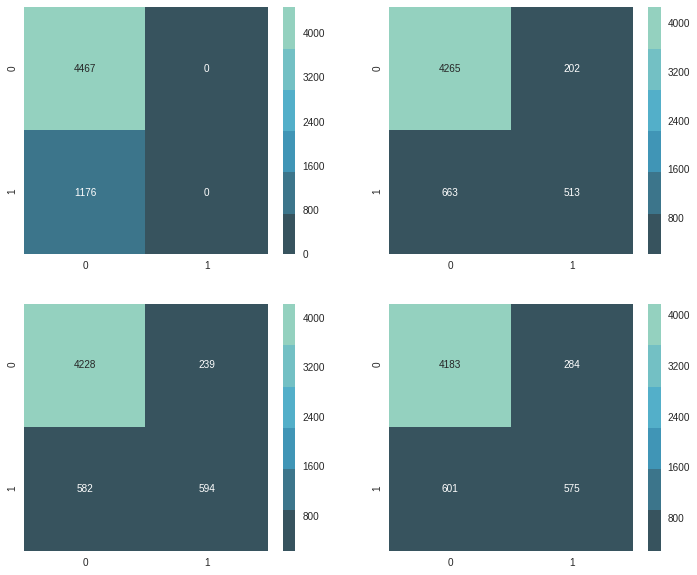

In [299]:
clr = sns.color_palette("GnBu_d")
fig, ax = plt.subplots(2,2, figsize=(12,10))
sns.heatmap(confusion_matrix(y_test,ypred_svm3), annot=True, fmt=".0f", ax=ax[0,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_dtree3), annot=True, fmt=".0f", ax=ax[0,1], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_logreg3), annot=True, fmt=".0f", ax=ax[1,0], cmap=clr)
sns.heatmap(confusion_matrix(y_test,ypred_knn3), annot=True, fmt=".0f", ax=ax[1,1], cmap=clr);

In [305]:
y_predproba_svm = svm_default.fit(X_train_new2,y_train).predict_proba(X_test_new2)
y_predproba_dtree = dtree_default.fit(X_train_new2,y_train).predict_proba(X_test_new2)
y_predproba_logreg = logreg_default.fit(X_train_new2,y_train).predict_proba(X_test_new2)
y_predproba_knn = knn_default.fit(X_train_new2,y_train).predict_proba(X_test_new2)

In [306]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test,y_predproba_svm[:,1])
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(y_test, y_predproba_dtree[:,1])
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_predproba_logreg[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_predproba_knn[:,1])

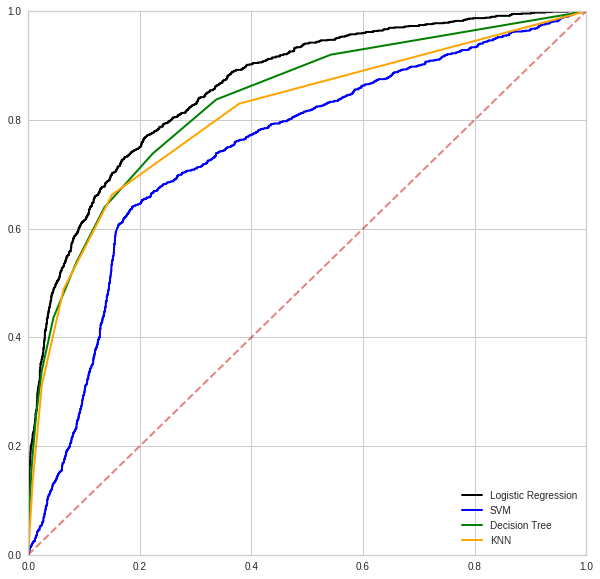

In [307]:
plt.figure(figsize=(10,10))
plt.plot(fpr_logreg, tpr_logreg, lw=2, alpha=1, color='black', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, lw=2, alpha=1, color='blue', label='SVM')
plt.plot(fpr_dtree, tpr_dtree, lw=2, alpha=1, color='green', label='Decision Tree')
plt.plot(fpr_knn, tpr_knn, lw=2, alpha=1, color='orange', label=f'KNN')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")